# 1. Configuration

## 1-1. Import

In [1]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from copy import deepcopy

## 1-2. Dir

In [2]:
DATA_DIR = "/home/pervinco/Datasets/BKAI_IGH_NeoPolyp"
IMG_DIR = f"{DATA_DIR}/train/train"
GT_DIR = f"{DATA_DIR}/train_gt/train_gt"

In [3]:
images = sorted(glob(f"{IMG_DIR}/*.jpeg"))
labels = sorted(glob(f"{GT_DIR}/*.jpeg"))

print(len(images), len(labels))

1000 1000


# 2. Sample visualize

## 2-1. Choice single sample

In [4]:
idx = random.randint(0, len(images))
sample_image_file, sample_label_file = images[idx], labels[idx]

(995, 1280, 3) (995, 1280, 3)


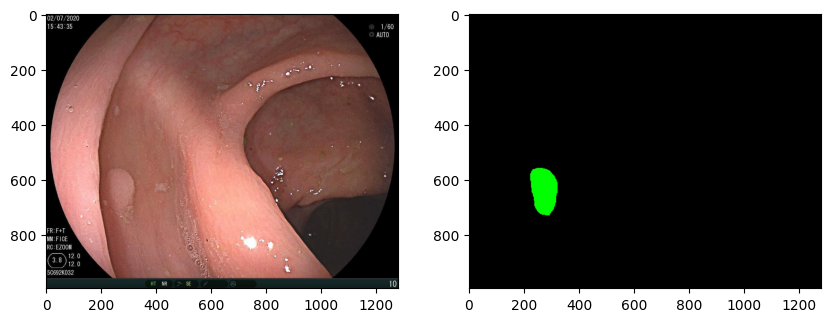

In [5]:
sample_image = cv2.imread(sample_image_file)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

sample_label = cv2.imread(sample_label_file)
sample_label = cv2.cvtColor(sample_label, cv2.COLOR_BGR2RGB)

print(sample_image.shape, sample_label.shape)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)

plt.subplot(1, 2, 2)
plt.imshow(sample_label)

## 2-2. Overlay(image + mask)

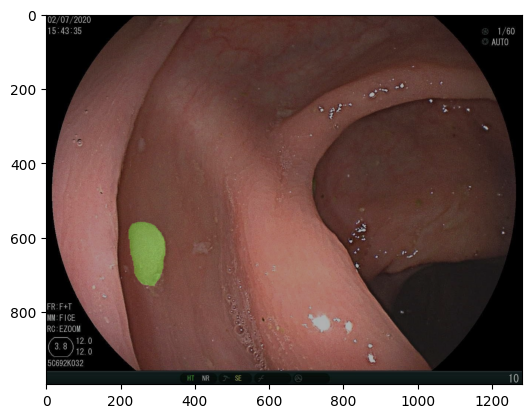

In [6]:
alpha = 0.7
beta = 0.3

overlayed = cv2.addWeighted(sample_image, alpha, sample_label, beta, 0)

plt.imshow(overlayed)

## 2-3. Mask data analysis

In [7]:
copy_label = deepcopy(sample_label)

데이터 구성에는 Red, Green, Black으로 구성되어 있다고 하지만 마스크 값을 보면 아래와 다르다.
- Red color: neoplastic polyps [255, 0, 0]
- Green color: non-neoplastic polyps [0, 255, 0]
- Black color: background, [0, 0, 0]

In [8]:
non_background_pixels = copy_label[np.any(copy_label != [0, 0, 0], axis=-1)] # 모든 픽셀 중에서 배경색 (예: 검은색)을 제외한 픽셀만 선택

unique_pixels = np.unique(non_background_pixels, axis=0) # 유일한 픽셀 값 파악
print(len(unique_pixels))

with open("./single_mask.txt", "w") as f:
    for pixel in unique_pixels:
        f.write(f"{pixel}\n")

875


검은색 픽셀[0, 0, 0]을 제외한, 유의미한 픽셀 전체를 사용해 마스크를 생성해보면 ground-truth 보다 noise가 추가되어 있는 것을 볼 수 있다.

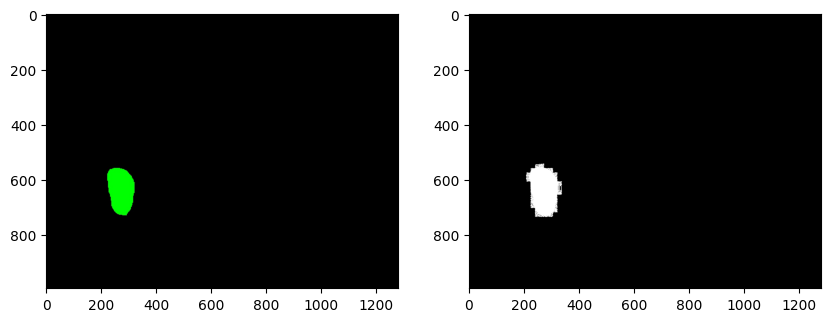

In [9]:
mask = np.any(copy_label != [0, 0, 0], axis=-1)
copy_label[mask] = [255, 255, 255]

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(sample_label)

plt.subplot(1, 2, 2)
plt.imshow(copy_label)

single_mask.txt를 살펴봤을 때 Red 또는 Green 값이 100이상의 값들임을 확인할 수 있다.

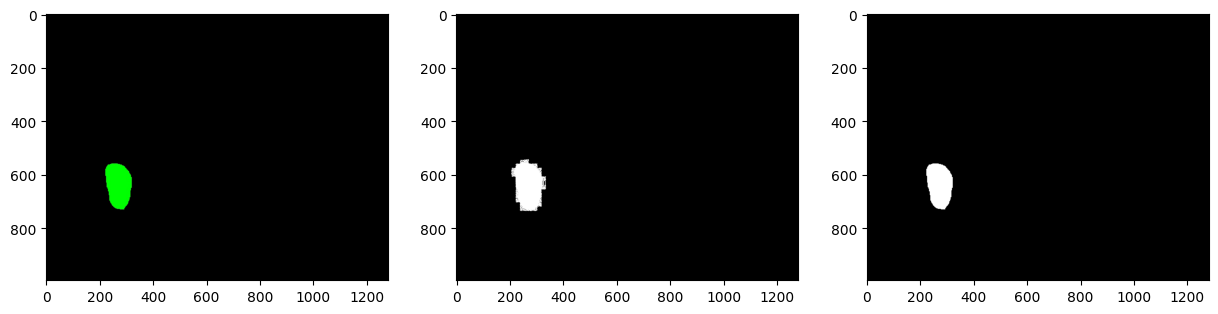

In [10]:
red_mask = sample_label[:, :, 0] >= 100
green_mask = sample_label[:, :, 1] >= 100

# 두 조건 중 하나라도 만족하는 픽셀 합치기
combined_mask = np.logical_or(red_mask, green_mask)

# 조건을 만족하는 픽셀을 흰색으로 표시 (예시)
result_image = np.zeros_like(sample_label)
result_image[combined_mask] = [255, 255, 255]

plt.figure(figsize=(15, 8))

plt.subplot(1, 3, 1)
plt.imshow(sample_label)

plt.subplot(1, 3, 2)
plt.imshow(copy_label)

plt.subplot(1, 3, 3)
plt.imshow(result_image)

# 3. Dataset Analysis

## 3-1. image per mask

In [11]:
data = []
total_red, total_green, total_black = 0, 0, 0
for label_file in labels:
    file_name = label_file.split('/')[-1].split('.')[0]
    red_count, green_count = 0, 0

    sample_label = cv2.imread(label_file)
    sample_label = cv2.cvtColor(sample_label, cv2.COLOR_BGR2RGB)
    
    red_mask = sample_label[:, :, 0] >= 100
    green_mask = sample_label[:, :, 1] >= 100
    black_mask = ~red_mask & ~green_mask

    red_count = np.sum(red_mask)
    green_count = np.sum(green_mask)
    black_count = np.sum(black_mask)

    total_red += red_count
    total_green += green_count
    total_black += black_count

    data.append({
        'image_file': file_name,
        'red_count': red_count,
        'green_count': green_count,
        'black_count': black_count
    })

df = pd.DataFrame(data)
csv_path = './pixel_counts.csv'
df.to_csv(csv_path, index=False)


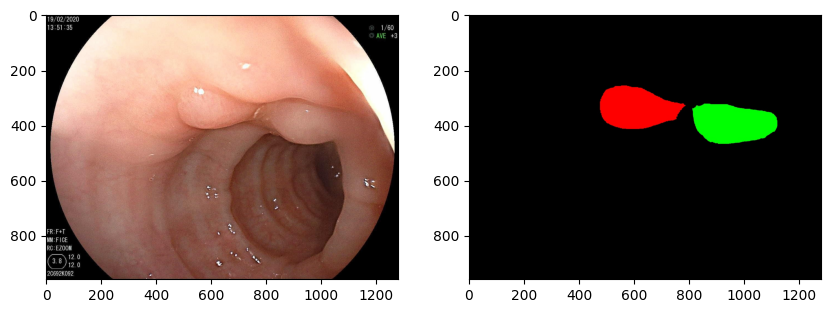

In [19]:
image1, label1 = images[107], labels[107]

image1 = cv2.imread(image1)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

label1 = cv2.imread(label1)
label1 = cv2.cvtColor(label1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image1)

plt.subplot(1, 2, 2)
plt.imshow(label1)

[57663478, 8413571, 1192086328]


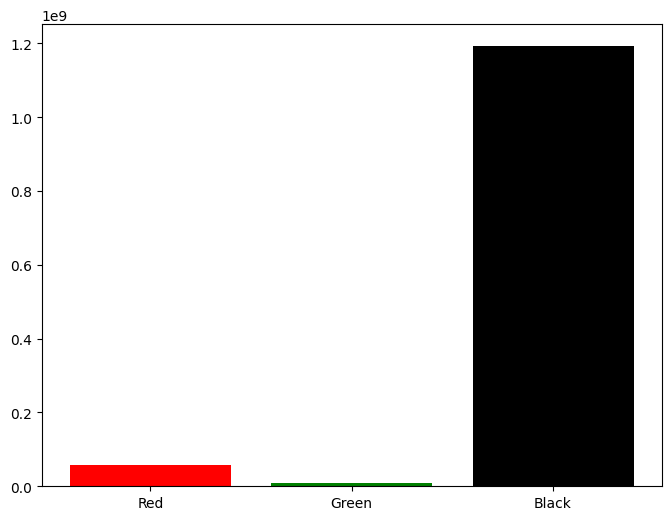

In [33]:
labels = ['Red', 'Green', 'Black']
values = [total_red, total_green, total_black]
colors = ['red', 'green', 'black']

print(values)
plt.figure(figsize=(8,6))
plt.bar(labels, values, color=colors)
plt.show()